In [1]:
import pandas as pd

In [2]:
# importing the raw cadaster & catastici data

catastici = pd.read_csv('data\catastici_1741.csv')
cadaster = pd.read_csv("data/cadaster_1808.csv")

In [3]:
# convert the parcel categories string into an Array(String)

cadaster['parcelCategories'] = cadaster['parcelCategories'].apply(lambda x: eval(x))

In [4]:
# we extract the italian words in the cadaster used for naming
# the goal of this is to align the object types between the cadaster and catastici

italian_words = cadaster['parcelCategories'].apply(pd.Series)
italian_words = italian_words.melt()

In [5]:
# print the italian words
# then use google translate and other tools to translate these words (manually)
print("Italian words: ",italian_words['value'].unique())

Italian words:  ['CASA' 'BOTTEGA' nan 'SCUOLA' 'TEATRO' 'LOCALE' 'MAGAZZENO' 'PIAZZA'
 'ORATORIO' 'GIARDINO' 'PALAZZO' 'LOGGIA' 'LUOGO' 'CORTO' 'SOTTOPORTICO'
 'APPARTAMENTO' 'STANZA' 'CAMERA' 'AREA' 'LOCANDA' 'CAFFE' 'ANDITO'
 'CHIESA' 'CAMPANILE' 'CASOTTO' 'CALLE' 'ATRIO' 'CASERMA' 'VOLTA'
 'TERAZZA' 'ACCESSO' 'FORNO' 'ORTO' 'ORTAGLIA' 'FABBRICA' 'MONASTERO'
 'SPAZIO' 'CONVENTO' 'SCALLA' 'OSPIZIO' 'CASETTA' 'CASINO' 'SAGRESTIA'
 'STRADA' 'CASALE' 'SINAGOGA' 'PORTICO' 'PRATO' 'FORNACE' 'MACELLO'
 'CANTIERE' 'INGRESSO' 'RIPOSTIGLIO' 'LATRINE' 'CARCERE' 'ARCHIVIO'
 'PASCOLO' 'FONDAMENTA' 'CAVANA' 'SCUDERIA' 'RAFFINARIA' 'ZECCA' 'CAPELLA'
 'CIMITERO' 'SQUERO' 'TAGLIAPIETRA' 'OSTERIA' 'OFFICINA' 'UFFICI'
 'VENDIVINO' 'TINTORIA' 'STALLA' 'TORRE']


In [6]:
# convert empty lists into None

cadaster['parcelCategory'] = cadaster['parcelCategories'].apply(lambda x: x[0] if x != [] else None)

In [7]:
# now we'll do the same for the catastici 
catastici['entryCategories'] = catastici['entryCategories'].apply(lambda x: eval(x))
catastici['entryCategories'] = catastici['entryCategories'].apply(lambda x: x[0] if x != [] else None)

In [8]:
print("English words: ",catastici['entryCategories'].unique())

English words:  ['housing' 'storage' 'shop' None 'hospitality' 'administration'
 'healthcare' 'entertainment' 'transport' 'palace' 'guild' 'religious']


In [9]:
# here we manually translated the terms from Italian to English
# since the english is more restrictive, we convert everything to english

translations = [
    ['CASA','housing',False], 
    ['BOTTEGA','shop',False], 
    ['SCUOLA','religious',True], 
    ['TEATRO','entertainment',False],
    ['LOCALE','shop',True],
    ['MAGAZZENO','storage', False],
    ['PIAZZA','None', True],
    ['ORATORIO','religious',False],
    ['GIARDINO','None',False],
    ['PALAZZO','palace',False],
    ['LOGGIA','guild',True],
    ['LUOGO','None', True],
    ['CORTO','None',True],
    ['SOTTOPORTICO','None',True],
    ['APPARTAMENTO','housing',False],
    ['STANZA','housing',False],
    ['CAMERA','housing',False],
    ['AREA','None', True],
    ['LOCANDA','hospitality',False],
    ['CAFFE','shop',False],
    ['ANDITO','None',True],
    ['CHIESA','relgious',False],
    ['CAMPANILE','religious',True],
    ['CASOTTO','housing',False],
    ['CALLE','None',True],
    ['ATRIO','None',True],
    ['CASERMA','administration',True],
    ['VOLTA','administration',True],
    ['TERAZZA','None',True],
    ['ACCESSO','None',True],
    ['FORNO','shop',False],
    ['ORTO','None',True],
    ['ORTAGLIA','None',True],
    ['FABRICA','shop',True],
    ['MONASTERO','religious',False],
    ['SPAZIO','None',True],
    ['CONVENT','religious',False],
    ['SCALLA','None',True],
    ['OSPIZIO','healthcare',False],
    ['CASETTA','housing',False],
    ['CASINO','entertainment',False],
    ['UFFICI','administration',True]
]

In [10]:
# convert the list into a pandas dataframe for merging

translations = pd.DataFrame(translations,columns = ['italian','english','help'])

In [11]:
# merge the catastici and the cadaster with the translation 

merged_cata = catastici.merge(translations, right_on = 'english', left_on = 'entryCategories')
merged_cada = cadaster.merge(translations, right_on = 'italian', left_on = 'parcelCategory')

In [12]:
# restrict to specific columns
cata = merged_cata[['cadaster1808Correspondance','cadaster1808ClosestParcel','italian','english','entryOwnerText']]
cata.columns = ['cadaster1808Correspondance','cadaster1808ClosestParcel','italian','english','1748Owner']

In [13]:
# restrict to specific columns
cada = merged_cada[['parcelOwnerText','english','area','bounds','parcelNumber','subParcelNumber']]
cada.columns = ['1808Owner','english','area','bounds','parcelNumber','subParcelNumber']

In [14]:
# remove the rows that contain None
cada2 = cada[cada['english'] != "None"]

# develop some metrics 
total_area_cada = cada2['area'].sum()
prop_cada = cada2.groupby("english")['area'].sum()/total_area_cada

In [15]:
# convert closest parcel to an object for merging 
cata['cadaster1808ClosestParcel'] = cata['cadaster1808ClosestParcel'].astype(str)

cata2 = cata.merge(cada, left_on = 'cadaster1808ClosestParcel',right_on = 'parcelNumber')

<ipython-input-15-f895ddd1f639>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cata['cadaster1808ClosestParcel'] = cata['cadaster1808ClosestParcel'].astype(str)


NameError: name 'cata2' is not defined

In [16]:
# overall metrics
total_area = cata2['area'].sum()
prop_cata = cata2.groupby('english_x')['area'].sum().sort_values() / total_area

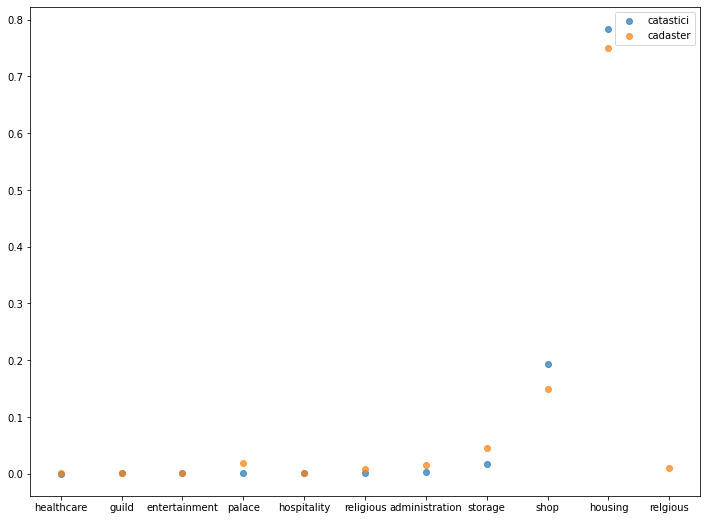

In [17]:
# comparing the data types between the two 
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (12,9))

ax.scatter(prop_cata.index, prop_cata.values, label = 'catastici', alpha = 0.7)
ax.scatter(prop_cada.index, prop_cada.values, label = 'cadaster', alpha = 0.7)
plt.legend()

### Connect to the geometrics
This will let us plot the comparisons and individual datasets

In [18]:
import geopandas
gdf = geopandas.read_file('data/cadaster_1808.geojson')

In [19]:
# drop None values
cata2.dropna(subset=['english_x','english_y'], inplace=True)

In [20]:
# define the group by for the location metadata
parcel_grouped = cata2.groupby('cadaster1808Correspondance')\
    .agg({'english_x': list,'english_y': list,'area':'mean', '1748Owner': \
    list, '1808Owner': list}).reset_index()

In [21]:
# question: how to add a value 

parcel_grouped['english_cata'] = parcel_grouped['english_x'].apply(lambda x: x[0])
parcel_grouped['english_cada'] = parcel_grouped['english_y'].apply(lambda x: x[0])
parcel_grouped['1748Owner'] = parcel_grouped['1748Owner'].apply(lambda x: x[0])
parcel_grouped['1808Owner'] = parcel_grouped['1808Owner'].apply(lambda x: x[0])
parcel_grouped.drop(['english_x','english_y'], axis =1, inplace=True)

In [22]:
parcel_grouped[parcel_grouped['english_cata'] != parcel_grouped['english_cada']]

,cadaster1808Correspondance,area,1748Owner,1808Owner,english_cata,english_cada
0,3.0,80.042,Padre Felippo Rota per eredi della quondam Dom...,BELLI Angelo Livellario di Lorenzo Tiepolo,housing,shop
2,8.0,105.043,Vincenzo e fratelli Grimani,BRAGADINI Giovanni q. Gaspare,storage,housing
3,9.0,161.716,Ferigo Calbo,CROTTA Lucrezia vedova CALVO,housing,shop
4,11.0,993.866,Zuanne et Fratelli Toderini,"TODARINI Luigi q. Giuseppe, e Ferdinando q. Te...",housing,shop
5,15.0,667.818,Scola di San Fantin,DEMANIO Suddetto [NAZIONALE],housing,shop
...,...,...,...,...,...,...
1384,11872.0,422.203,Zuanne de Boni Zavater,CITTA' DI VENEZIA,guild,shop
1390,11885.0,114.905,"Anzolo, e Fratelli Marcello",MARCELLO Angelo q.m Gerolamo,storage,housing
1391,11886.0,213.598,"Anzolo Marcello, e Fratelli",MARCELLO Angelo q.m Gerolamo,storage,housing
1395,11895.0,119.464,Pietro Grimani San Luca,SAGREDO Giovanni q.m Francesco,shop,housing


In [23]:
parcel_grouped['parcel_number'] = parcel_grouped['cadaster1808Correspondance']
del parcel_grouped['cadaster1808Correspondance']

In [24]:
parcel_grouped.parcel_number = parcel_grouped.parcel_number.astype(int).astype(str)

In [25]:
parcel_grouped['change'] = parcel_grouped.apply(lambda x: 1 if x['english_cata'] != x['english_cada'] else 0, axis =1)

In [63]:
t = gdf.merge(parcel_grouped)

In [64]:
t.to_file("data/comparison.geojson", driver='GeoJSON')


In [27]:
cada['parcel_number'] = cada['parcelNumber']
del cada['parcelNumber']

<ipython-input-27-ff08c9747145>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cada['parcel_number'] = cada['parcelNumber']


In [28]:
cada.drop(['bounds'],axis=1, inplace=True)

C:\Users\Venia\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
cada[cada['parcel_number'] == '15545 1/2']

,1808Owner,english,area,subParcelNumber,parcel_number
15530,N.,housing,582.868,NaN,15545 1/2


## Extract the family names 

In [36]:
list_family_names = pd.read_csv("https://raw.githubusercontent.com/vminvsky/FDH_project/main/data/Venice_list_of_names.csv", sep='\t"')

list_family_names = list_family_names.apply(lambda x: x.str.replace("\"", ""))

list_family_names.columns = [ 'family', '1808', 'Noble', 'Citoyen', 'famille.12e.siecle']

list_family_names.index = list_family_names.index.map(lambda x: x.replace("\"", ""))

family_name_options = list_family_names['family'].values


In [ ]:
from fuzzywuzzy import fuzz, process
tenant_name = cada['1808Owner'].apply(lambda x: process.extractOne(x,family_name_options, scorer=fuzz.token_set_ratio))


In [37]:
cada['1808Owner']

0                          PAGANI - Concorso de' creditori
1                               TIEPOLO Gerolamo q. Almorò
2        PAGANI - Concorso come sopra al N° 1 [de' cred...
3                                TIEPOLO Lorenzo q. Almorò
4                                ZEN Antonio q. Sebastiano
                               ...                        
22656                       Coletti Nicolò quondam Florian
22657    Vigonzo Margarita, vedova di Morosini Francesc...
22658      Suddetto [Zen Carlo, e fratelli quondam Renier]
22659                                             Suddetta
22660    TOGNELLA Marco q.m. Alessandro, PLONDER Don Pi...
Name: 1808Owner, Length: 22661, dtype: object